## Lecture 05

# Data Preprocessing: Handling Missing Data, Transformations, and Outliers



## Introduction



Today we will cover four critical aspects of data preprocessing that you will encounter in almost every real-world data analysis project. We will learn how to identify and handle missing data, when and how to transform variables, understand different types of missingness, and deal with outliers effectively.



By the end of this lecture, you will be able to prepare messy, real-world datasets for analysis and modeling using Python.



---



## Part 1: Missing Data - Types and Detection



### Understanding Types of Missingness



Missing data is not random. Understanding why data is missing helps us choose the right strategy to handle it.



**Three Types of Missingness:**



1. **Missing Completely at Random (MCAR)** - The missingness has no relationship with any other variable. For example, a survey response is missing because the page didn't load due to a server error.



2. **Missing at Random (MAR)** - The missingness is related to other observed variables but not to the missing value itself. For example, younger people might be less likely to report their income, but within age groups, missingness is random.



3. **Missing Not at Random (MNAR)** - The missingness is related to the value itself. For example, people with very high incomes might refuse to report it.



**Why does this matter?**



The type of missingness determines which imputation methods are appropriate. MCAR allows for simple methods like deletion. MAR works well with most imputation techniques. MNAR requires careful consideration and domain expertise.



---




In [ ]:
# Let's start by importing necessary libraries and creating a sample dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy import stats

# Set random seed for reproducibility
# This ensures we get the same results each time we run the code
np.random.seed(42)

# Create a sample dataset with different types of missing data
n_samples = 200

# Generate base data
age = np.random.normal(35, 10, n_samples)
income = 20000 + age * 1000 + np.random.normal(0, 5000, n_samples)
experience = age - 22 + np.random.normal(0, 2, n_samples)
satisfaction = np.random.randint(1, 11, n_samples)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'experience': experience,
    'satisfaction': satisfaction
})

# Introduce MCAR - completely random missingness in satisfaction scores
# We randomly select 20% of indices and set them to missing
mcar_indices = np.random.choice(df.index, size=int(0.2 * len(df)), replace=False)
df.loc[mcar_indices, 'satisfaction'] = np.nan

# Introduce MAR - income missing more often for younger people
# People under 30 have 40% chance of missing income, others have 10% chance
young_mask = df['age'] < 30
df.loc[young_mask & (np.random.rand(len(df)) < 0.4), 'income'] = np.nan
df.loc[~young_mask & (np.random.rand(len(df)) < 0.1), 'income'] = np.nan

# Introduce MNAR - high experience people don't report experience
# People with experience > 15 years have 50% chance of not reporting it
high_exp_mask = df['experience'] > 15
df.loc[high_exp_mask & (np.random.rand(len(df)) < 0.5), 'experience'] = np.nan

print("Dataset created with different types of missingness")
print(df.head(10))


Dataset created with different types of missingness
         age        income  experience  satisfaction
0  39.967142  61756.078332   14.778286           NaN
1  33.617357  56421.279620   10.418607           NaN
2  41.476885  66892.141597   19.487373           3.0
3  50.230299  75499.308824   28.324260           3.0
4  32.658466  45770.119413    9.758335           NaN
5  32.658630  47969.505231   11.904330           NaN
6  50.792128  73367.304491         NaN          10.0
7  42.674347  65243.277046   20.389588           5.0
8  30.305256           NaN    8.545847           4.0
9  40.425600  79689.257889         NaN          10.0



Missing values count:
age              0
income          31
experience      38
satisfaction    40
dtype: int64

Percentage of missing data:
age              0.0
income          15.5
experience      19.0
satisfaction    20.0
dtype: float64


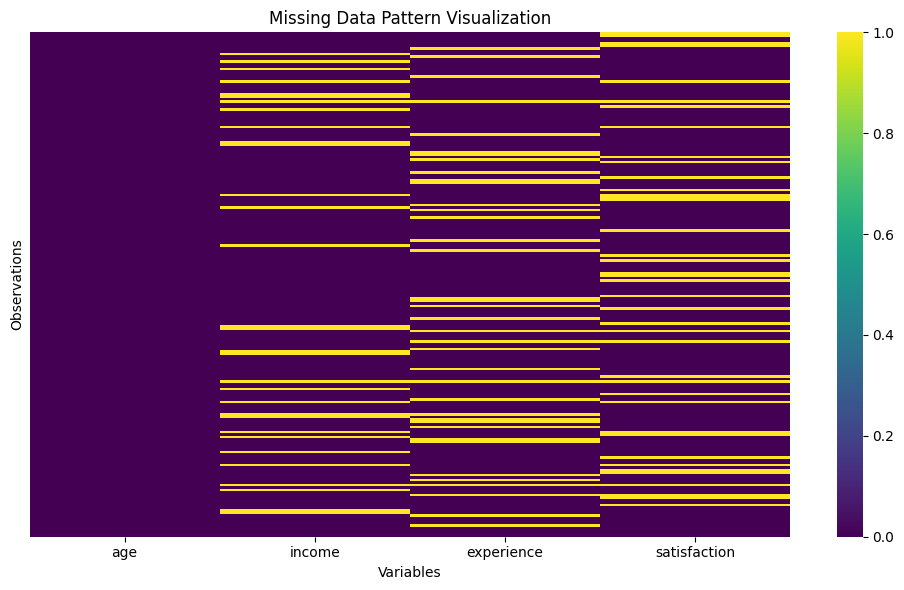


Yellow indicates missing values, purple indicates present values


In [ ]:
# Check for missing values
# The isnull() method returns True for missing values, sum() counts them
print("\nMissing values count:")
print(df.isnull().sum())

# Calculate percentage of missing data for each column
# This helps us decide whether to impute or drop the column
print("\nPercentage of missing data:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage)

# Visualize missing data patterns
# The missingno library is great for this, but we'll use a heatmap
plt.figure(figsize=(10, 6))
# Create a binary matrix where 1 represents missing and 0 represents present
# The isnull() method returns True/False, which gets converted to 1/0
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern Visualization')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.tight_layout()
plt.show()

print("\nYellow indicates missing values, purple indicates present values")




---



## Part 2: Imputation Methods



### When Should We Use Imputation?



**Use imputation when:**

- The percentage of missing data is small to moderate (typically under 40%)

- The data is MCAR or MAR

- Dropping rows would result in significant data loss

- The variable is important for analysis



**Avoid imputation when:**

- Missing data percentage is very high (over 60-70%)

- The data is MNAR and you cannot model the missingness properly

- The variable is not critical for your analysis



### Common Imputation Methods



1. **Mean/Median/Mode Imputation** - Replace missing values with the central tendency. Simple but ignores relationships between variables.



2. **Forward Fill / Backward Fill** - Use the previous or next value. Good for time series data.



3. **KNN Imputation** - Use values from similar observations. Better preserves relationships but computationally expensive.



4. **Multiple Imputation** - Create multiple datasets with different imputations. Most statistically sound but complex.



---




In [ ]:
# Method 1: Mean/Median Imputation
# We use median instead of mean because it is less sensitive to outliers

# Create a copy of the dataframe to preserve the original
df_mean_imputed = df.copy()

# SimpleImputer is a class that performs imputation
# strategy='median' tells it to use the median value of each column
# We could also use 'mean', 'most_frequent', or 'constant'
imputer_median = SimpleImputer(strategy='median')

# fit_transform does two things:
# 1. fit() calculates the median from the training data
# 2. transform() replaces missing values with that median
# We select only numeric columns for imputation
numeric_cols = ['age', 'income', 'experience', 'satisfaction']
df_mean_imputed[numeric_cols] = imputer_median.fit_transform(df[numeric_cols])

print("After Median Imputation:")
print(df_mean_imputed.isnull().sum())
print("\nFirst few rows:")
print(df_mean_imputed.head())


After Median Imputation:
age             0
income          0
experience      0
satisfaction    0
dtype: int64

First few rows:
         age        income  experience  satisfaction
0  39.967142  61756.078332   14.778286           5.0
1  33.617357  56421.279620   10.418607           5.0
2  41.476885  66892.141597   19.487373           3.0
3  50.230299  75499.308824   28.324260           3.0
4  32.658466  45770.119413    9.758335           5.0


In [ ]:
# Method 2: KNN Imputation
# KNN finds the k nearest neighbors (similar observations) and uses their values

df_knn_imputed = df.copy()

# KNNImputer finds k nearest neighbors based on available features
# n_neighbors=5 means it will look at the 5 most similar observations
# weights='distance' means closer neighbors have more influence
# A higher n_neighbors makes imputation more stable but less local
# A lower n_neighbors makes it more sensitive to local patterns
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# KNN requires all features to be numeric and on similar scales
# So we might want to scale first, but for simplicity we'll use it directly
df_knn_imputed[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

print("After KNN Imputation:")
print(df_knn_imputed.isnull().sum())
print("\nFirst few rows:")
print(df_knn_imputed.head())


After KNN Imputation:
age             0
income          0
experience      0
satisfaction    0
dtype: int64

First few rows:
         age        income  experience  satisfaction
0  39.967142  61756.078332   14.778286      4.508392
1  33.617357  56421.279620   10.418607      5.526365
2  41.476885  66892.141597   19.487373      3.000000
3  50.230299  75499.308824   28.324260      3.000000
4  32.658466  45770.119413    9.758335      6.007483


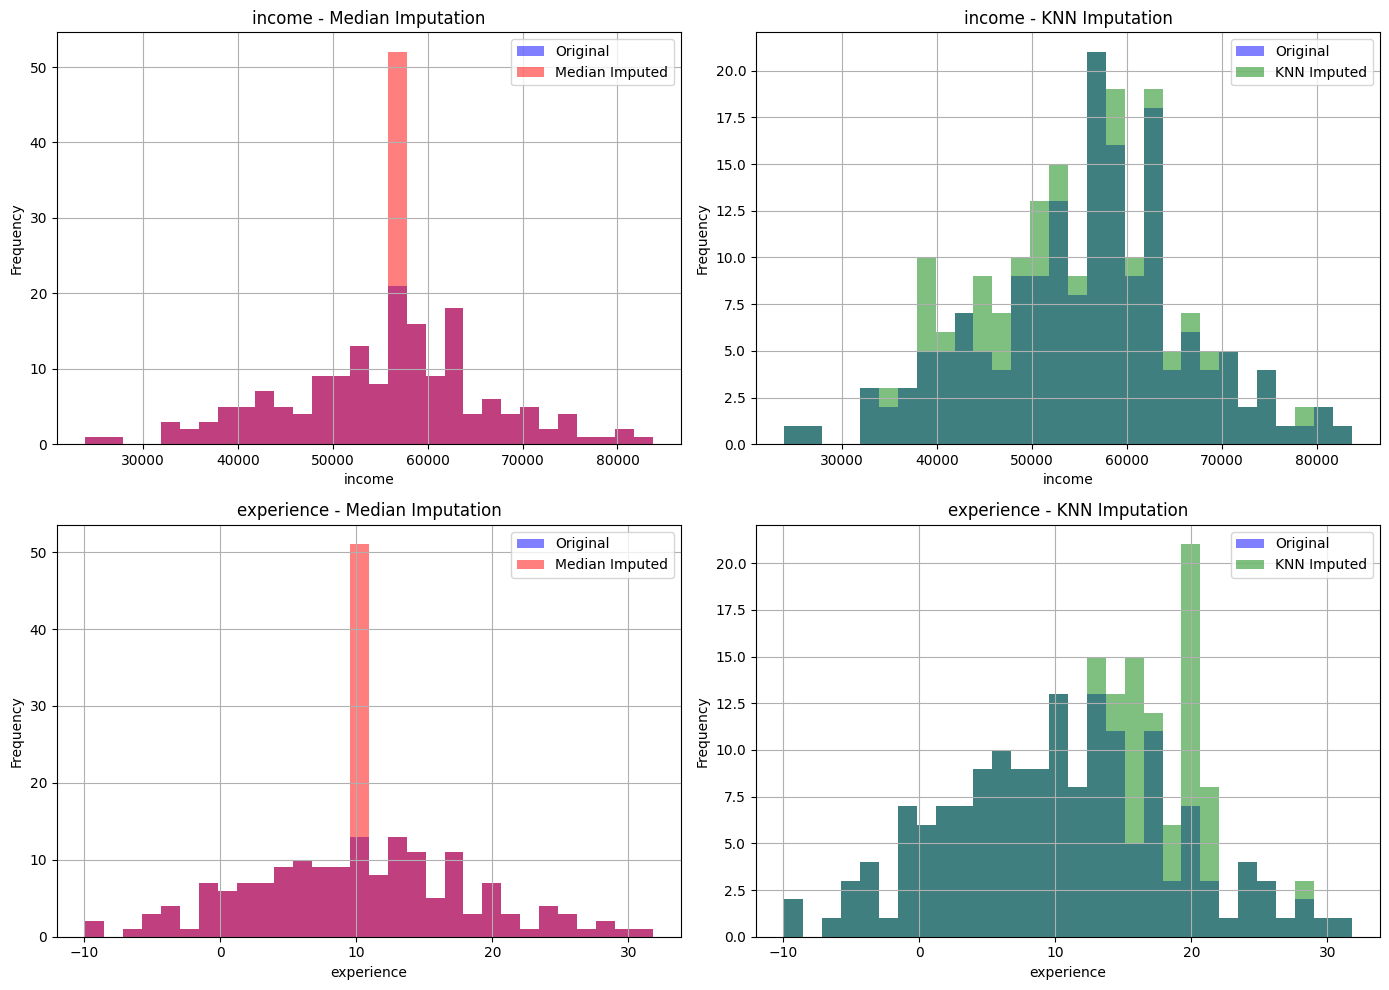

Notice how KNN imputation preserves the distribution better than median imputation


In [ ]:
# Compare the distributions before and after imputation
# This helps us see if imputation has distorted the data

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

columns_to_plot = ['income', 'experience']

for idx, col in enumerate(columns_to_plot):
    ax = axes[idx, 0]
    # Plot original data (excluding missing values)
    # dropna() removes rows with missing values for this comparison
    df[col].dropna().hist(bins=30, alpha=0.5, label='Original', ax=ax, color='blue')
    df_mean_imputed[col].hist(bins=30, alpha=0.5, label='Median Imputed', ax=ax, color='red')
    ax.set_title(f'{col} - Median Imputation')
    ax.legend()
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

    ax = axes[idx, 1]
    df[col].dropna().hist(bins=30, alpha=0.5, label='Original', ax=ax, color='blue')
    df_knn_imputed[col].hist(bins=30, alpha=0.5, label='KNN Imputed', ax=ax, color='green')
    ax.set_title(f'{col} - KNN Imputation')
    ax.legend()
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Notice how KNN imputation preserves the distribution better than median imputation")




---



## Part 3: Variable Transformations



### When Do We Need Transformations?



**Apply transformations when:**

- The variable has a skewed distribution (most values on one side)

- You need to meet assumptions for statistical tests or models

- You want to reduce the impact of outliers

- You need to make variables comparable (different scales)



**Common transformations:**



1. **Normalization (Min-Max Scaling)** - Scales data to a range, typically 0 to 1. Use when you need bounded values or when the distribution is not Gaussian.



2. **Standardization (Z-score)** - Centers data around mean 0 with standard deviation 1. Use when you need zero-centered data or for algorithms sensitive to scale like KNN, SVM, or neural networks.



3. **Log Transformation** - Reduces right skewness. Use for highly skewed data or when relationships are multiplicative.



4. **Power Transformation (Box-Cox, Yeo-Johnson)** - Makes data more Gaussian. Use when you need normally distributed data for statistical tests.



---




In [ ]:
.01, 0.1, 0.44, 0.1 , 0.44, 0.32 ............... 13, 15, 90, 40, 50...... 234567, 46789, 36789............0-1

In [ ]:
marks = 33, 56, 67, 33........... 55, 90, 83

In [ ]:
# Let's create a skewed variable to demonstrate transformations
# Many real-world variables like income, house prices are right-skewed

np.random.seed(42)
# Exponential distribution creates right-skewed data
skewed_data = np.random.exponential(scale=2, size=1000)

# Create a DataFrame
df_transform = pd.DataFrame({'original': skewed_data})

print("Original data statistics:")
print(df_transform['original'].describe())

# Check skewness
# Skewness > 1 or < -1 indicates highly skewed data
# Skewness between 0.5 and 1 (or -0.5 and -1) indicates moderate skew
skewness = df_transform['original'].skew()
print(f"\nSkewness: {skewness:.2f}")
print("Positive skewness indicates right-skewed data (tail extends to the right)")


Original data statistics:
count    1000.000000
mean        1.945012
std         1.945020
min         0.009286
25%         0.538313
50%         1.373565
75%         2.727660
max        16.344891
Name: original, dtype: float64

Skewness: 1.87
Positive skewness indicates right-skewed data (tail extends to the right)


In [ ]:
# Transformation 1: Log Transformation
# Natural logarithm compresses large values more than small values

# We add 1 to avoid log(0) which is undefined
# log1p is equivalent to log(1 + x)
df_transform['log_transformed'] = np.log1p(df_transform['original'])

print("\nLog-transformed data statistics:")
print(df_transform['log_transformed'].describe())
print(f"Skewness after log: {df_transform['log_transformed'].skew():.2f}")



Log-transformed data statistics:
count    1000.000000
mean        0.904114
std         0.576080
min         0.009243
25%         0.430680
50%         0.864393
75%         1.315780
max         2.853298
Name: log_transformed, dtype: float64
Skewness after log: 0.43


In [ ]:
# Transformation 2: Min-Max Normalization
# Formula: (X - X_min) / (X_max - X_min)
# This scales all values to be between 0 and 1

# MinMaxScaler performs normalization
# feature_range=(0, 1) sets the output range
# We could use any range, like (-1, 1) with feature_range=(-1, 1)
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

# fit_transform learns the min and max from the data, then scales it
# We reshape because scikit-learn expects 2D input (samples, features)
df_transform['minmax_scaled'] = scaler_minmax.fit_transform(
    df_transform[['original']]
)

print("\nMin-Max scaled data statistics:")
print(df_transform['minmax_scaled'].describe())
print("Notice all values are now between 0 and 1")



Min-Max scaled data statistics:
count    1000.000000
mean        0.118497
std         0.119066
min         0.000000
25%         0.032385
50%         0.083516
75%         0.166408
max         1.000000
Name: minmax_scaled, dtype: float64
Notice all values are now between 0 and 1


In [ ]:
# Transformation 3: Standardization (Z-score normalization)
# Formula: (X - mean) / standard_deviation
# Results in mean=0 and std=1

# StandardScaler performs standardization
# with_mean=True subtracts the mean (centering)
# with_std=True divides by standard deviation (scaling)
scaler_standard = StandardScaler(with_mean=True, with_std=True)

df_transform['standardized'] = scaler_standard.fit_transform(
    df_transform[['original']]
)

print("\nStandardized data statistics:")
print(df_transform['standardized'].describe())
print("Notice mean is approximately 0 and std is approximately 1")



Standardized data statistics:
count    1.000000e+03
mean    -3.730349e-17
std      1.000500e+00
min     -9.957199e-01
25%     -7.235930e-01
50%     -2.939469e-01
75%      4.025872e-01
max      7.407166e+00
Name: standardized, dtype: float64
Notice mean is approximately 0 and std is approximately 1


In [ ]:
# Transformation 4: Power Transformation (Yeo-Johnson)
# Automatically finds the best power transformation to make data Gaussian

# PowerTransformer applies power transformations
# method='yeo-johnson' works with positive and negative values
# method='box-cox' only works with positive values
# standardize=True also standardizes after transformation
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

df_transform['power_transformed'] = power_transformer.fit_transform(
    df_transform[['original']]
)

print("\nPower-transformed data statistics:")
print(df_transform['power_transformed'].describe())
print(f"Skewness after power transform: {df_transform['power_transformed'].skew():.2f}")
print("This transformation tries to make the distribution as normal as possible")



Power-transformed data statistics:
count    1.000000e+03
mean    -1.243450e-17
std      1.000500e+00
min     -1.779354e+00
25%     -8.123813e-01
50%      3.624794e-02
75%      7.852433e-01
max      2.568535e+00
Name: power_transformed, dtype: float64
Skewness after power transform: 0.07
This transformation tries to make the distribution as normal as possible


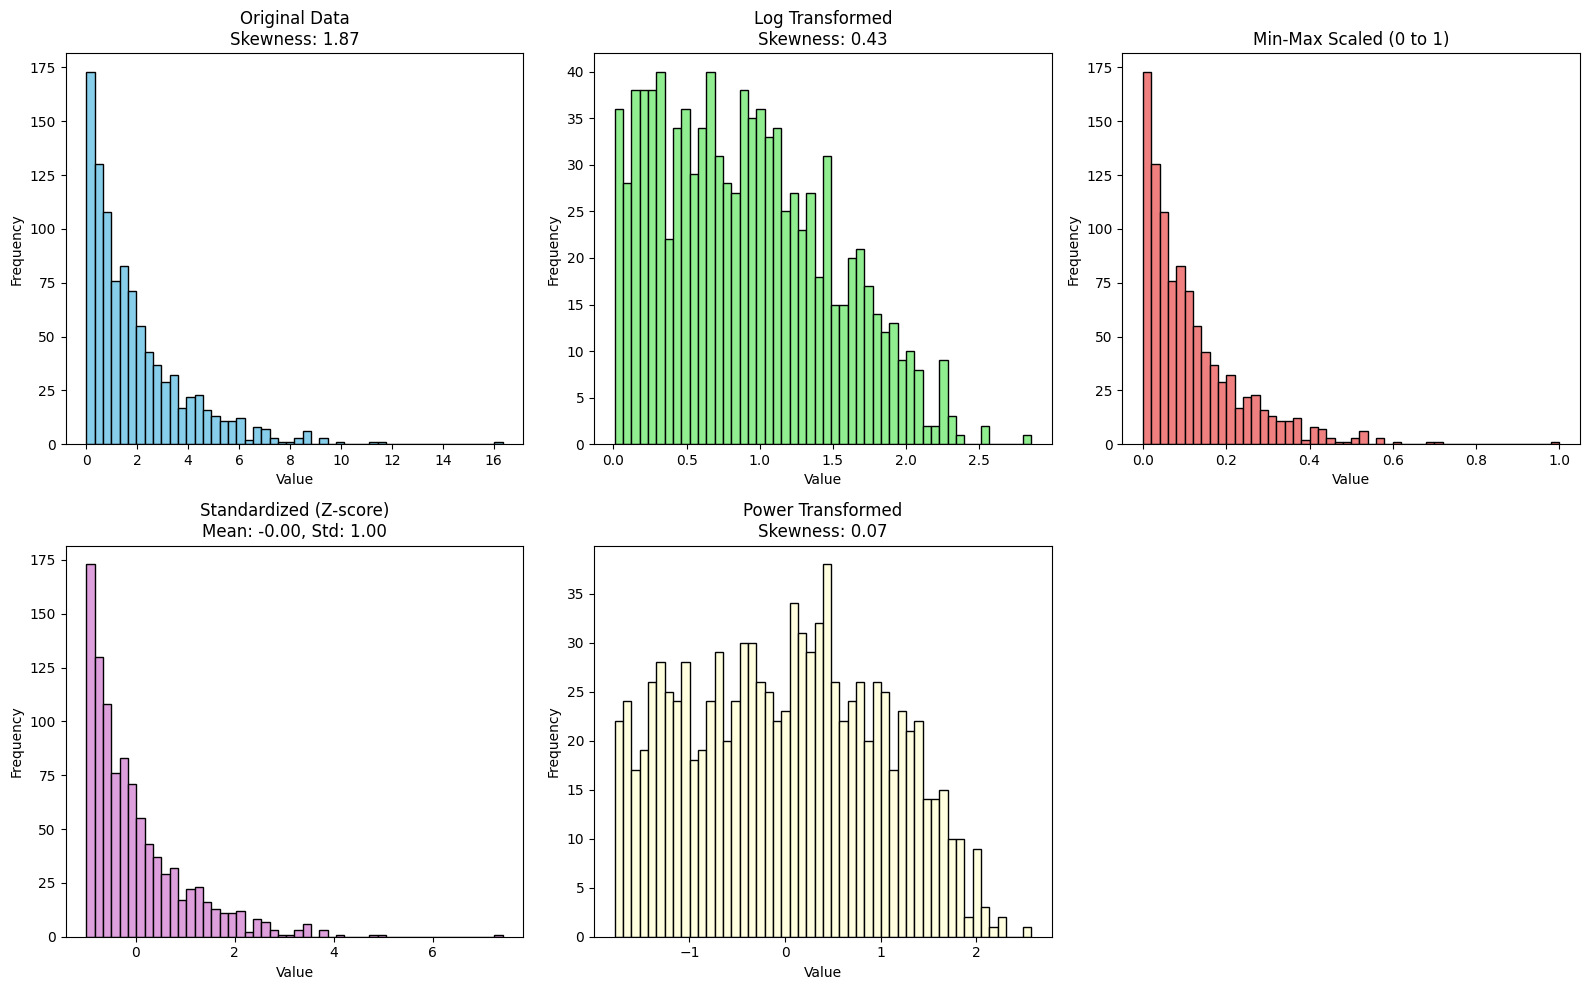


Key Observations:
- Log transformation reduced skewness significantly
- Min-Max scaling changed the range but not the distribution shape
- Standardization centered the data around 0
- Power transformation made the distribution closest to normal


In [ ]:
# Visualize all transformations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Original data
axes[0, 0].hist(df_transform['original'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_title(f'Original Data\nSkewness: {df_transform["original"].skew():.2f}')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# Log transformed
axes[0, 1].hist(df_transform['log_transformed'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_title(f'Log Transformed\nSkewness: {df_transform["log_transformed"].skew():.2f}')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

# Min-Max scaled
axes[0, 2].hist(df_transform['minmax_scaled'], bins=50, edgecolor='black', color='lightcoral')
axes[0, 2].set_title('Min-Max Scaled (0 to 1)')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')

# Standardized
axes[1, 0].hist(df_transform['standardized'], bins=50, edgecolor='black', color='plum')
axes[1, 0].set_title(f'Standardized (Z-score)\nMean: {df_transform["standardized"].mean():.2f}, Std: {df_transform["standardized"].std():.2f}')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

# Power transformed
axes[1, 1].hist(df_transform['power_transformed'], bins=50, edgecolor='black', color='lightyellow')
axes[1, 1].set_title(f'Power Transformed\nSkewness: {df_transform["power_transformed"].skew():.2f}')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

# Remove the empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Log transformation reduced skewness significantly")
print("- Min-Max scaling changed the range but not the distribution shape")
print("- Standardization centered the data around 0")
print("- Power transformation made the distribution closest to normal")




---



## Part 4: Outlier Detection and Handling


### What Are Outliers?



Outliers are observations that deviate significantly from other observations. They can occur due to measurement errors, data entry errors, or they may represent genuine extreme values.



**Why handle outliers?**

- They can skew statistical analyses

- They can disproportionately influence model training

- They may indicate data quality issues



**Detection Methods:**



1. **Statistical Methods (Z-score, IQR)** - Based on distance from central tendency

2. **Visualization (Box plots, Scatter plots)** - Visual inspection

3. **Machine Learning Methods (Isolation Forest, Local Outlier Factor)** - For complex, high-dimensional data



---




Data statistics:
count    205.000000
mean      50.138820
std       14.881556
min      -20.000000
25%       42.856486
50%       50.051135
75%       55.219416
max      140.000000
Name: value, dtype: float64


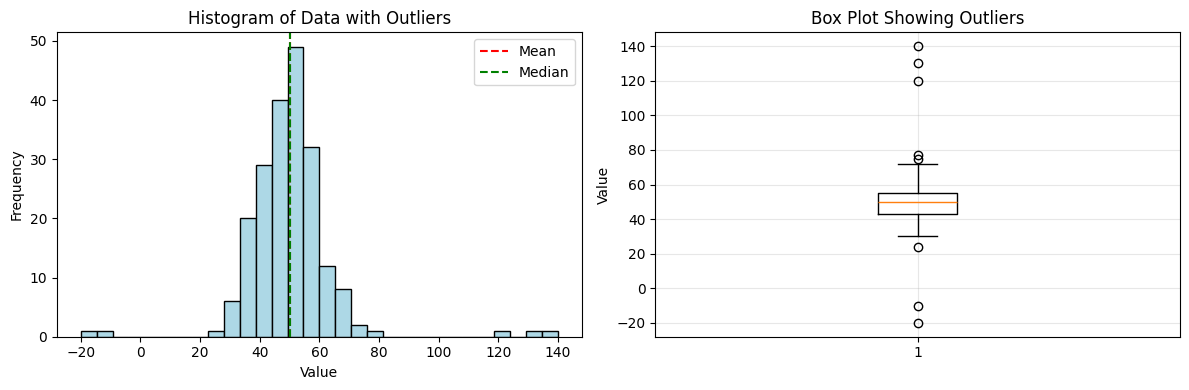


In the box plot, points outside the whiskers are potential outliers


In [ ]:
# Create data with outliers
np.random.seed(42)
normal_data = np.random.normal(50, 10, 200)
# Add some outliers (extreme values)
outliers = np.array([120, 130, -20, 140, -10])
data_with_outliers = np.concatenate([normal_data, outliers])

df_outliers = pd.DataFrame({'value': data_with_outliers})

print("Data statistics:")
print(df_outliers['value'].describe())

# Visualize the data with outliers
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_outliers['value'], bins=30, edgecolor='black', color='lightblue')
plt.title('Histogram of Data with Outliers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.axvline(df_outliers['value'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df_outliers['value'].median(), color='green', linestyle='--', label='Median')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_outliers['value'], vert=True)
plt.title('Box Plot Showing Outliers')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nIn the box plot, points outside the whiskers are potential outliers")


In [ ]:
# Method 1: Z-Score Method
# Z-score measures how many standard deviations away from the mean a point is
# Typically, |Z| > 3 indicates an outlier (99.7% of data falls within 3 std devs)

# Calculate Z-scores for each value
# Formula: Z = (X - mean) / std
z_scores = np.abs(stats.zscore(df_outliers['value']))

# Set threshold for outlier detection
# threshold=3 means we flag points more than 3 standard deviations away
threshold = 3

# Create a boolean mask where True indicates an outlier
outlier_mask_zscore = z_scores > threshold

print(f"Number of outliers detected by Z-score method: {outlier_mask_zscore.sum()}")
print(f"\nOutlier values:")
print(df_outliers[outlier_mask_zscore]['value'].values)


Number of outliers detected by Z-score method: 5

Outlier values:
[120. 130. -20. 140. -10.]


In [ ]:
# Method 2: IQR (Interquartile Range) Method
# IQR is the range between the 25th and 75th percentile
# This method is more robust to outliers than Z-score

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_outliers['value'].quantile(0.25)
Q3 = df_outliers['value'].quantile(0.75)

# IQR is the difference between Q3 and Q1
IQR = Q3 - Q1

# Define outlier boundaries
# Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers
# The factor 1.5 is standard, but you can adjust it (higher = fewer outliers)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create boolean mask for outliers
outlier_mask_iqr = (df_outliers['value'] < lower_bound) | (df_outliers['value'] > upper_bound)

print(f"IQR Method:")
print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"\nNumber of outliers detected by IQR method: {outlier_mask_iqr.sum()}")
print(f"Outlier values:")
print(df_outliers[outlier_mask_iqr]['value'].values)


IQR Method:
Q1 (25th percentile): 42.86
Q3 (75th percentile): 55.22
IQR: 12.36
Lower bound: 24.31
Upper bound: 73.76

Number of outliers detected by IQR method: 8
Outlier values:
[ 23.80254896  74.63242112  77.20169167 120.         130.
 -20.         140.         -10.        ]


In [ ]:
# Handling outliers - Different approaches

# Approach 1: Remove outliers
# Simply drop the rows containing outliers
df_outliers_removed = df_outliers[~outlier_mask_iqr].copy()
print("After removing outliers:")
print(f"Original size: {len(df_outliers)}")
print(f"After removal: {len(df_outliers_removed)}")
print(f"Removed: {len(df_outliers) - len(df_outliers_removed)} rows")


After removing outliers:
Original size: 205
After removal: 197
Removed: 8 rows


In [ ]:
# Approach 2: Cap outliers (Winsorization)
# Replace outliers with the boundary values instead of removing them
# This preserves the number of observations

df_outliers_capped = df_outliers.copy()

# Replace values below lower_bound with lower_bound
df_outliers_capped.loc[df_outliers_capped['value'] < lower_bound, 'value'] = lower_bound

# Replace values above upper_bound with upper_bound
df_outliers_capped.loc[df_outliers_capped['value'] > upper_bound, 'value'] = upper_bound

print("\nAfter capping outliers:")
print(df_outliers_capped['value'].describe())



After capping outliers:
count    205.000000
mean      49.680862
std        9.909210
min       24.312091
25%       42.856486
50%       50.051135
75%       55.219416
max       73.763810
Name: value, dtype: float64


In [ ]:
# Approach 3: Transform to reduce impact
# Use log transformation to compress extreme values
# This is useful when you want to keep outliers but reduce their influence

df_outliers_transformed = df_outliers.copy()

# Add a constant to handle negative values if present
# Then apply log transformation
min_value = df_outliers['value'].min()
if min_value <= 0:
    shift = abs(min_value) + 1
    df_outliers_transformed['value'] = np.log1p(df_outliers['value'] + shift)
else:
    df_outliers_transformed['value'] = np.log1p(df_outliers['value'])

print("\nAfter log transformation:")
print(df_outliers_transformed['value'].describe())



After log transformation:
count    205.000000
mean       4.247497
std        0.321192
min        0.693147
25%        4.172177
50%        4.277376
75%        4.346651
max        5.087596
Name: value, dtype: float64


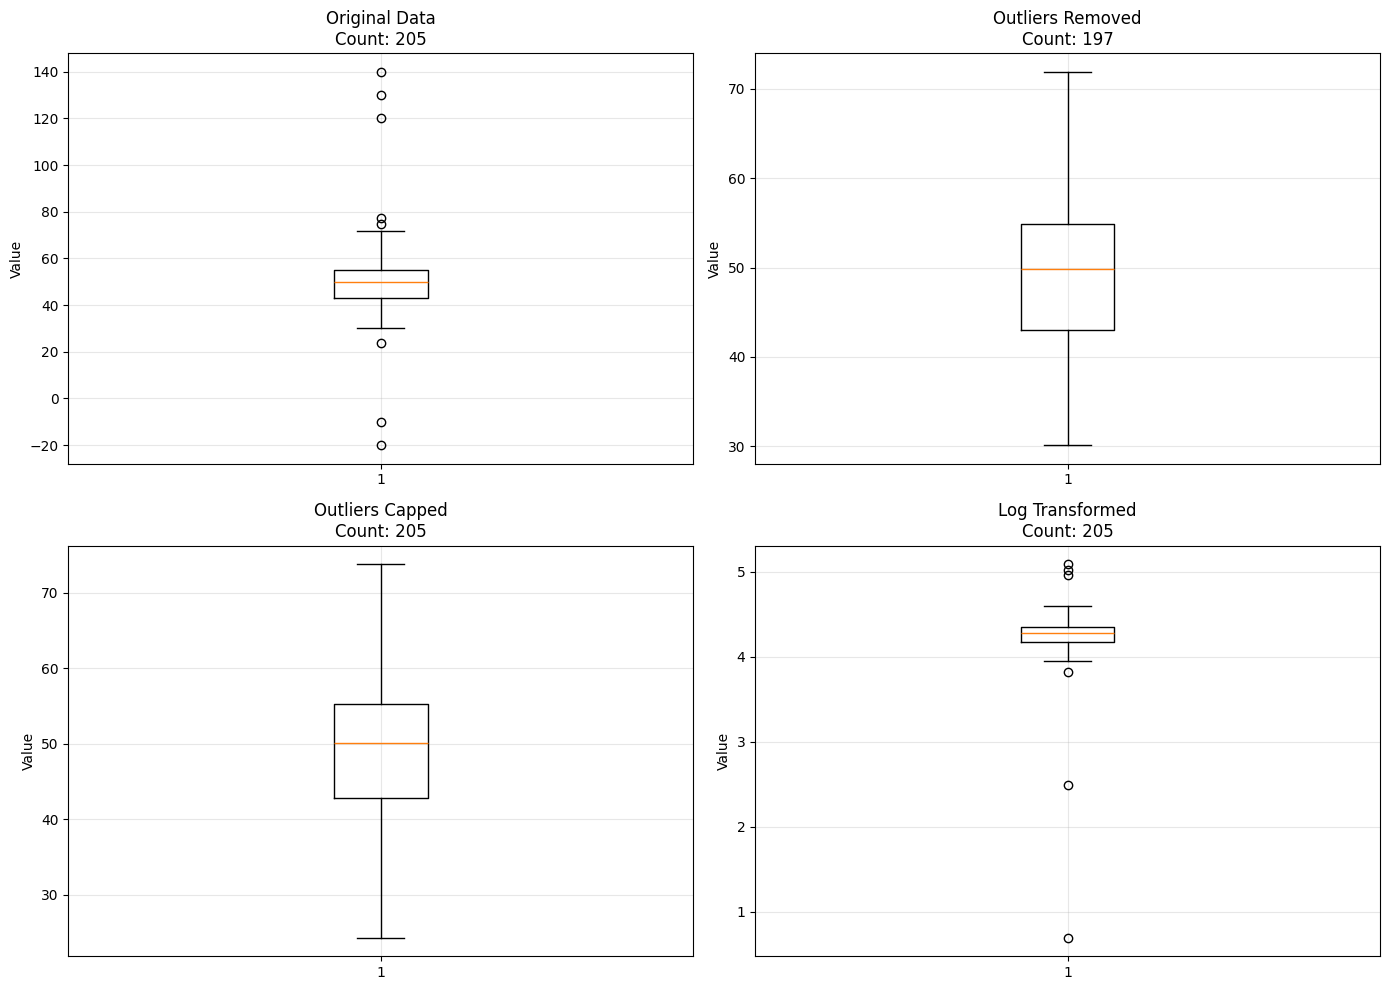


Comparison of methods:
Original - Mean: 50.14, Std: 14.88
Removed - Mean: 49.46, Std: 8.80
Capped - Mean: 49.68, Std: 9.91
Transformed - Mean: 4.25, Std: 0.32


In [ ]:
# Compare all approaches visually
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original data
axes[0, 0].boxplot(df_outliers['value'], vert=True)
axes[0, 0].set_title(f'Original Data\nCount: {len(df_outliers)}')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Outliers removed
axes[0, 1].boxplot(df_outliers_removed['value'], vert=True)
axes[0, 1].set_title(f'Outliers Removed\nCount: {len(df_outliers_removed)}')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

# Outliers capped
axes[1, 0].boxplot(df_outliers_capped['value'], vert=True)
axes[1, 0].set_title(f'Outliers Capped\nCount: {len(df_outliers_capped)}')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# Outliers transformed
axes[1, 1].boxplot(df_outliers_transformed['value'], vert=True)
axes[1, 1].set_title(f'Log Transformed\nCount: {len(df_outliers_transformed)}')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison of methods:")
print(f"Original - Mean: {df_outliers['value'].mean():.2f}, Std: {df_outliers['value'].std():.2f}")
print(f"Removed - Mean: {df_outliers_removed['value'].mean():.2f}, Std: {df_outliers_removed['value'].std():.2f}")
print(f"Capped - Mean: {df_outliers_capped['value'].mean():.2f}, Std: {df_outliers_capped['value'].std():.2f}")
print(f"Transformed - Mean: {df_outliers_transformed['value'].mean():.2f}, Std: {df_outliers_transformed['value'].std():.2f}")




---



## Summary and Best Practices



### Key Takeaways



**Missing Data:**

- Always investigate why data is missing before handling it

- Use simple imputation (mean/median) for MCAR with low missingness

- Use KNN or multiple imputation for MAR

- Be very cautious with MNAR - consider if imputation is appropriate



**Transformations:**

- Use log transformation for right-skewed data

- Use standardization for algorithms sensitive to scale

- Use normalization when you need bounded ranges

- Use power transformations when you need normally distributed data



**Outliers:**

- Always visualize your data first

- Use IQR method for robustness

- Remove outliers only if they are errors

- Cap or transform outliers if they are genuine extreme values



**General Advice:**

- Document all preprocessing steps for reproducibility

- Keep the original data unchanged

- Validate that preprocessing improved your analysis

- Consider the domain context when making decisions




In [ ]:
# Final comprehensive example combining all techniques

# Load or create a dataset
np.random.seed(42)
n = 300

df_final = pd.DataFrame({
    'age': np.random.normal(35, 15, n),
    'income': np.random.exponential(50000, n),
    'score': np.random.normal(75, 15, n)
})

# Introduce missing values
df_final.loc[np.random.choice(df_final.index, 30), 'income'] = np.nan
df_final.loc[np.random.choice(df_final.index, 20), 'score'] = np.nan

# Add outliers
df_final.loc[np.random.choice(df_final.index, 5), 'score'] = np.random.uniform(150, 200, 5)

print("Original Dataset:")
print(df_final.describe())
print("\nMissing values:")
print(df_final.isnull().sum())

# Step 1: Handle missing data
imputer = KNNImputer(n_neighbors=5)
df_final[['age', 'income', 'score']] = imputer.fit_transform(df_final[['age', 'income', 'score']])

print("\n\nAfter imputation:")
print(df_final.isnull().sum())

# Step 2: Handle outliers in score
Q1 = df_final['score'].quantile(0.25)
Q3 = df_final['score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
df_final['score'] = df_final['score'].clip(lower=lower_bound, upper=upper_bound)

print("\nAfter handling outliers:")
print(df_final['score'].describe())

# Step 3: Transform skewed variable (income)
df_final['income_log'] = np.log1p(df_final['income'])

print("\nAfter log transformation of income:")
print(f"Original income skewness: {df_final['income'].skew():.2f}")
print(f"Transformed income skewness: {df_final['income_log'].skew():.2f}")

# Step 4: Standardize for modeling
scaler = StandardScaler()
df_final[['age_scaled', 'income_scaled', 'score_scaled']] = scaler.fit_transform(
    df_final[['age', 'income_log', 'score']]
)

print("\n\nFinal preprocessed dataset ready for analysis:")
print(df_final.head())
print("\nAll preprocessing steps completed successfully!")



---

## Questions and Discussion

What questions do you have about missing data, transformations, or outliers?

Think about your own datasets - which of these techniques would be most useful for your projects?

